
##  Bidirectional dc-to-dc converter with LCL filter
###  Control Design
##### Professor Humberto Pinheiro, Ph.D.
##### Fundamentos de Eletrônica de Potência - DPEE 1072


In [2]:
!pip install numpy
!pip install scipy
import numpy as np
from numpy import pi
from scipy import sqrt, exp, cos, matrix, vstack, hstack, zeros
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import mpld3
import math as m
import cmath
import sympy as sp
sp.init_printing()
import control

You should consider upgrading via the 'c:\users\israe\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\israe\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


RuntimeError: The current Numpy installation ('c:\\users\\israe\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\numpy\\__init__.py') fails to pass a sanity check due to a bug in the windows runtime. See this issue for more information: https://tinyurl.com/y3dm3h86

## Introduction
In this document, the design of a current controller for a bidirectional dc-to-dc converter is exemplified where a simple PI controller in continuous time domine will be considered.
![dc-to-dc2.png](BI2.png)


The transistors $Q_1$ and $Q_2$ are controlled in a complementary way, that is, when $Q_1$ is on the transistor $Q_2$ is off. Similarly, when $Q_2$ is on $Q_1$ is off.

For the controller design, it is considered that the average voltage synthesized by the converter over a sampling period $T_s$ is proportional to the duty cycle $d$. Besides, the open-loop gain cross over frequency is considered to be smaller than the switching and sampling frequencies. Therefore, the high-frequency ripple resulting from the PWM operation on the filter inductor current and capacitor voltage can be neglected. 

 ![dc-to-dc bidirectinal1.png](PWM2.png)
                (c) Regular Sampled PWM where $T_s=2T_{sw}$.
                
   $T_s$: Sampling Period.
  
  $T_{sw}$: Switching Period.

The above figure also indicates the signal that defines the interruption service routine execution: the green arrow. It is also indicated the time duration of the AD conversion, the controller, and modulation. This computation delay should be considered in the controller design.

 ![dc-to-dc bidirectinal1.png](Transportdelay.png)

In the Figure above $T$ is the sampling period $T_s$ and $TPER$ is the peak value of the triangular carrier, which typically assumes values between zero and $TPER$.

For frequencies below $\frac{1}{2T_s}$ the following approximation is valid

${e^{ - sT}} \approx \frac{{1 - sT}}{{1 + sT}}$


In [2]:
Prated=3000
E1=400
E2=200   
d=200/400  

L1=66.*10**-6
C=4.7*10**-6
L2=42*10**-6
fsw=100000
Tsw=1/fsw
Ts=2*Tsw
print ( ' fsw=', fsw/1000,'kHz')
print ( ' Tsw=', Tsw*10**6,'us')
print ( ' fsample=', fsw/2/1000,'kHz')
print ( ' Ts=', Ts*10**6,'us')
print( ' L1=',L1*10**6,'uH')
print( ' C=',C*10**6,'uF')
print( ' L2=',L2*10**6,'uH')


 fsw= 100.0 kHz
 Tsw= 10.0 us
 fsample= 50.0 kHz
 Ts= 20.0 us
 L1= 65.99999999999999 uH
 C= 4.7 uF
 L2= 42.0 uH


The $LCL$ filter can be represented in the frequency domain as:

![dc-to-dc bidirectinal1.png](LCLfilter.png)

 From the above circuit it is possible to obtain the blue part of the closed loop block diagram shown below
 
 ![dc-to-dc bidirectinal1.png](Blockdiagram.png)


where 

${k_1} = \frac{1}{{C{L_2}{L_1}}}$

${\omega _n} = \sqrt {\frac{{{L_1} + {L_2}}}{{C{L_1}{L_2}}}} $

${k_2} = \frac{1}{{{L_2}}}$

${\omega _{n2}} = \sqrt {\frac{1}{{C{L_1}}}} $

For the controller design the battery voltage can be considered as an external disturbance. In addition the voltage $V_{in}=E_1$.

The controller are represented by the block diagram in yellow. The PI controller has to paramenter to be adjusted, that are, the zero $z$ and the gain $k_{pi}$. The PI transferfuction can be expressed as:

$\frac{{{k_{pi}}(s + z)}}{s}$


In [3]:
wn=np.sqrt((L1+L2)/(L1*L2*C))
print('wn=',wn,'rad/s')
print( 'fn=wn/(2pi)=',wn/2/np.pi/1000,'kHz')
wn2=np.sqrt(1/(L1*C))
print('wn2=',wn2,'rad/s')
print( 'fn2=wn2/(2pi)=',wn2/2/np.pi/1000,'kHz')
k1=1/(C*L1*L2)
print ( 'k1=',k1)

wn= 91047.14579638324 rad/s
fn=wn/(2pi)= 14.490603307902873 kHz
wn2= 56777.87093562022 rad/s
fn2=wn2/(2pi)= 9.036478817637615 kHz
k1= 76755395904332.08


### PI Design 
Here the rootlocus method will be used to select the parameters of the PI controller.  The open-loop transferfuction without the PI gain, $k_pi$, is:

$OLTF = \frac{{(s + z)}}{s}\frac{{1 - sT}}{{1 + sT}}\frac{{{k_1}}}{{s({s^2} + {\omega _{n}}^2)}}$

Let us select the zero and plot the rootlocus. 




In [4]:

z=2*np.pi*100
PI=control.tf([1, z],[1,0])
print(PI)
TD=control.tf([-Ts,1],[Ts,1])

print(TD)
Gp=E1*k1*control.tf([1],[1,0,wn*wn,0])
print(Gp)
OLTF=PI*TD*Gp
print(OLTF)




s + 628.3
---------
    s


-2e-05 s + 1
------------
2e-05 s + 1


    3.07e+16
----------------
s^3 + 8.29e+09 s


    -6.14e+11 s^2 + 3.032e+16 s + 1.929e+19
----------------------------------------------
2e-05 s^5 + s^4 + 1.658e+05 s^3 + 8.29e+09 s^2



<function matplotlib.pyplot.show(*args, **kw)>

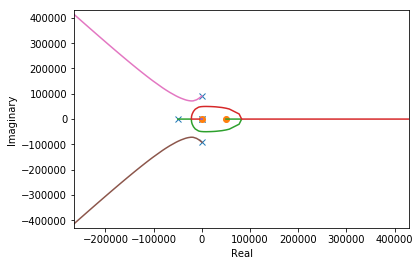

In [5]:
[R,K]=control.root_locus(OLTF)
plt.show


Let us now select the gain $k_{pi}$


In [6]:
print (R)
print (K)

[[-5.00000000e+04+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.63797881e-12-9.10471458e+04j
   3.63797881e-12+9.10471458e+04j]
 [-5.00000000e+04+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.63797881e-12-9.10471458e+04j
   3.63797881e-12+9.10471458e+04j]
 [-4.60894439e+04+0.00000000e+00j -1.29058201e+03+0.00000000e+00j
  -1.29058196e+03+0.00000000e+00j -6.64696068e+02-9.00211564e+04j
  -6.64696068e+02+9.00211564e+04j]
 [-4.27851808e+04+0.00000000e+00j -4.10857010e+03+0.00000000e+00j
  -7.66583416e+02+0.00000000e+00j -1.16983283e+03-8.92466869e+04j
  -1.16983283e+03+8.92466869e+04j]
 [-4.25611022e+04+0.00000000e+00j -4.27351450e+03+0.00000000e+00j
  -7.61178535e+02+0.00000000e+00j -1.20210237e+03-8.91973804e+04j
  -1.20210237e+03+8.91973804e+04j]
 [-4.23345926e+04+0.00000000e+00j -4.44029539e+03+0.00000000e+00j
  -7.56196704e+02+0.00000000e+00j -1.23445767e+03-8.91479643e+04j
  -1.23445767e+03+8.91479643e+04j

In [7]:
kpi=0.0026
OLTF=kpi*OLTF
CLTF=OLTF/(1+OLTF)
print(CLTF)
#CLTF=control.minreal(CLTF)
#print(CLTF)



                  -3.193e+04 s^7 - 2.006e+07 s^6 - 1.849e+14 s^5 - 1.162e+17 s^4 + 6.617e+23 s^3 + 4.158e+26 s^2
---------------------------------------------------------------------------------------------------------------------------------
4e-10 s^10 + 4e-05 s^9 + 7.632 s^8 + 6.312e+05 s^7 + 4.405e+10 s^6 + 2.564e+15 s^5 + 6.86e+19 s^4 + 6.617e+23 s^3 + 4.158e+26 s^2



## Step Respose

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\matfuncs.py:711: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.196374e-55
  return solve(Q, P)


Text(0,0.5,'y(t)')

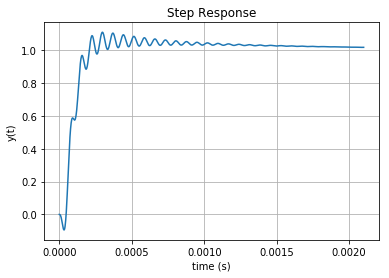

In [8]:
t=np.linspace(0.0,0.0021,1000)
[t1,y]=control.step_response(CLTF,t)
plt.plot(t1,y)
plt.title("Step Response")
plt.grid()
plt.xlabel("time (s)")
plt.ylabel("y(t)")


## Open Loop Frequency Response

<function matplotlib.pyplot.show(*args, **kw)>

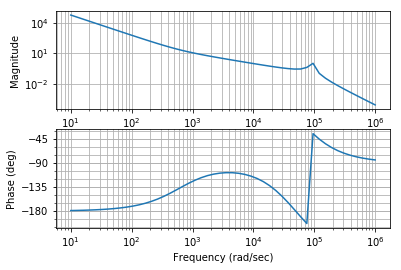

In [9]:
control.bode(OLTF)
plt.show

## Simulation Including the PWM
#### and the one sample transportation delay associated to the digital implementation

Transient response of $i_{L2}$ due to a step change in the reference.

![dc-to-dc bidirectinal1.png](steprepose_psim1.png)



Transient during the start-up


![dc-to-dc bidirectinal1.png](Startup.png)

## References
[1] k. Ogata, Engenharia de Controle Moderno

[2] Simone Buso, Paolo Mattavelli, Digital Control in Power Electronics